## 1. Load Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip -uq "/content/drive/My Drive/ICLR_Challenge/train" -d "/content/drive/My Drive/ICLR_Challenge/train"
# !unzip -uq "/content/drive/My Drive/ICLR_Challenge/test" -d "/content/drive/My Drive/ICLR_Challenge/test"

In [0]:
pwd

'/content'

In [0]:
# Adjust the figure file type
# !cd '/content/drive/My Drive/ICLR_Challenge/train/'
# !find . -name "*.jfif" -exec bash -c 'mv "$1" "${1%.jfif}".jpg' - '{}' \;

# !cd '/content/drive/My Drive/ICLR_Challenge/train/'
# !find . -name "*.gif" -exec bash -c 'mv "$1" "${1%.jfif}".jpg' - '{}' \;

!cd '/content/drive/My Drive/ICLR Challenge/test/test/'
!find . -name "*.jfif" -exec bash -c 'mv "$1" "${1%.jfif}".jpg' - '{}' \;

/bin/bash: line 0: cd: /content/drive/My Drive/ICLR Challenge/test/test/: No such file or directory


## 2. Model Training


In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
import torch.nn as nn

In [0]:
# Creating train and test directories
train_data_dir = '/content/drive/My Drive/ICLR Challenge/train/'
test_data_dir = '/content/drive/My Drive/ICLR Challenge/test/'

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder('/content/drive/My Drive/ICLR Challenge/', 
                                  train="train",
                                  test='test',
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(max_rotate=80,
                                                         flip_vert=True,
                                                         max_zoom=1.5,
                                                         max_lighting=0.5), 
                                  size=256, resize_method=ResizeMethod.SQUISH,
                                  bs = 96).normalize(imagenet_stats)

In [0]:
data.c

3

In [3]:
# to show the data
# data.show_batch(rows=2)

In [0]:
data.shape

In [5]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))

['healthy_wheat', 'leaf_rust', 'stem_rust'] 3 701 175


In [1]:
# This will create a transfer learninig model from resnet50 and mixup is used for regularization
learn = create_cnn(data, models.resnet50).mixup()

In [2]:
learn.fit_one_cycle(4)   

epoch,train_loss,valid_loss,time
0,3.568830,#na#,01:53
1,3.500969,#na#,01:53
2,3.511467,#na#,01:52
3,3.567305,#na#,01:53
4,3.535232,#na#,01:52
5,3.339363,#na#,01:52
6,5.328061,#na#,01:47
7,7.972949,#na#,01:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


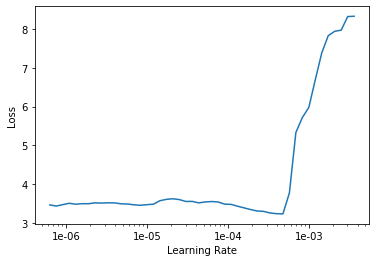

In [16]:
# 2. Unfreeze the model, run a script to find an optimal learning rate, and fine-tune the whole model.
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(11, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,time
0,3.533372,1.810161,02:14
1,3.343606,1.659140,02:17
2,3.157243,1.869747,02:14
3,2.990053,1.640273,02:14
4,2.789557,1.317441,02:16
5,2.582458,1.737451,02:14
6,2.399409,1.495401,02:15
7,2.241498,0.911271,02:16
8,2.117887,1.125561,02:14
9,1.990334,1.015609,02:12


In [0]:
learn.save('/content/drive/My Drive/ICLR Challenge/resnet50_epoch15_size256_96_fp16')

In [0]:
# 3. predicion
# preds, y = learn.get_preds(DatasetType.Test)

preds = []
for i in range(len(data.test_ds.x)):
    #print(i)
    p = learn.predict(data.test_ds.x[i])
    preds.append(p[2].numpy())

preds = np.array(preds)

In [20]:
import os
submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir(test_data_dir+'/test/')  if s.split('.')[1] != 'jfif']})
for i, c in enumerate(learn.data.classes):
#print(c)
  submission[c] = preds[:,i]
submission = submission[['ID', 'class1', 'class2', 'class3']] # Get same order as sample sub
submission.head()

healthy_wheat
leaf_rust
stem_rust


,ID,leaf_rust,stem_rust,healthy_wheat
0,Z63BLU,1.000000,1.507972e-09,1.177951e-15
1,OOALVQ,0.004332,9.956685e-01,4.843816e-13
2,NGZ2X2,0.001674,9.980732e-01,2.527326e-04
3,8NRRD6,0.279952,7.197857e-01,2.623598e-04
4,7HWYNO,0.000278,9.997147e-01,7.294351e-06


In [17]:
submission.shape

(610, 4)

In [0]:
import os
os.chdir("/content/drive/My Drive/ICLR Challenge/test")
!ls

'test (1)'


In [0]:
submission.to_csv('/content/drive/My Drive/ICLR Challenge/result_26fb_96bs_fp16_resnet50_256_fastai.csv', index=False)

In [0]:
submis